In [ ]:
import pandas as pd
from datetime import datetime, timedelta


import numpy as np

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
!pip install requests
import requests

In [ ]:
# Replace 'your_api_token_here' with your actual Tiingo API token
api_token = '006fb064a2f4e8c83cb5c22a1fbe4179be29a75e'
ticker = 'TSLA'

# Calculate the start date (5 years ago from today)
end_date = datetime.now()-timedelta(days=30)
start_date =  datetime(1960, 1, 1)

# Format dates as strings
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# URL for historical prices
url = f'https://api.tiingo.com/tiingo/daily/{ticker}/prices?startDate={start_date_str}&endDate={end_date_str}'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Token {api_token}'
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    print(f"Fetched {len(data)} days of data for tesla.")
else:
    print("Failed to fetch data. Status code:", response.status_code)


Fetched 3519 days of data for tesla.


In [ ]:
import pandas as pd
# Convert JSON data to pandas DataFrame
df = pd.DataFrame(data)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3519 entries, 0 to 3518
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3519 non-null   object 
 1   close        3519 non-null   float64
 2   high         3519 non-null   float64
 3   low          3519 non-null   float64
 4   open         3519 non-null   float64
 5   volume       3519 non-null   int64  
 6   adjClose     3519 non-null   float64
 7   adjHigh      3519 non-null   float64
 8   adjLow       3519 non-null   float64
 9   adjOpen      3519 non-null   float64
 10  adjVolume    3519 non-null   int64  
 11  divCash      3519 non-null   float64
 12  splitFactor  3519 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 357.5+ KB


In [ ]:
# Preprocess the data
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
data = df['close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))


In [ ]:
# Prepare data
seq_length = 60
def prepare_data(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

data_sequences = prepare_data(data, seq_length)

In [ ]:
 # Split into train and test sets (last 30 days for testing)
split = len(data_sequences) - 30
train_data = data_sequences[:split]
test_data = data_sequences[split:]


In [ ]:
# Reshape data for TimeGAN (samples, time steps, features)
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy as tf_legacy


In [ ]:
def build_generator(seq_length, n_features):
    model = tf.keras.Sequential()
    model.add(GRU(128, input_shape=(seq_length, n_features), return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    return model


In [ ]:
def build_discriminator(seq_length, n_features):
    model = tf.keras.Sequential()
    model.add(GRU(128, input_shape=(seq_length, n_features), return_sequences=True))
    model.add(GRU(64))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [ ]:
def build_encoder(seq_length, n_features):
    model = tf.keras.Sequential()
    model.add(GRU(128, input_shape=(seq_length, n_features), return_sequences=True))
    model.add(GRU(64))
    model.add(Dense(32))
    return model


In [ ]:
class TimeGAN:
    def __init__(self, seq_length, n_features):
        self.seq_length = seq_length
        self.n_features = n_features

        self.generator = build_generator(seq_length, n_features)
        self.discriminator = build_discriminator(seq_length, n_features)
        self.encoder = build_encoder(seq_length, n_features)

        self.optimizer = tf_legacy.Adam(learning_rate=0.0002, beta_1=0.5)

        # Compile models
        self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.encoder.compile(loss='mse', optimizer=self.optimizer)

        self.gan = self.build_gan()

    def build_gan(self):
        self.discriminator.trainable = False
        gan_input = Input(shape=(self.seq_length, self.n_features))
        x = self.generator(gan_input)
        gan_output = self.discriminator(x)
        gan = Model(inputs=gan_input, outputs=gan_output)
        gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        return gan

    def train(self, X_train, epochs=10000, batch_size=128):
        for epoch in range(epochs):
            # Train discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_sequences = X_train[idx]
            fake_sequences = self.generator.predict(np.random.normal(0, 1, (batch_size, self.seq_length, self.n_features)))
            d_loss_real = self.discriminator.train_on_batch(real_sequences, np.ones((batch_size, 1)))
            d_loss_fake = self.discriminator.train_on_batch(fake_sequences, np.zeros((batch_size, 1)))

            # Train generator
            g_loss = self.gan.train_on_batch(np.random.normal(0, 1, (batch_size, self.seq_length, self.n_features)), np.ones((batch_size, 1)))

            if epoch % 1000 == 0:
                print(f"Epoch {epoch} | Discriminator Loss: {0.5 * (d_loss_real[0] + d_loss_fake[0])} | Generator Loss: {g_loss}")

    def sample(self, n_samples):
        return self.generator.predict(np.random.normal(0, 1, (n_samples, self.seq_length, self.n_features)))


In [ ]:
# Instantiate TimeGAN
timegan = TimeGAN(seq_length, 1)

# Train TimeGAN
timegan.train(train_data, epochs=100, batch_size=128)

# Generate synthetic data
synthetic_data = timegan.sample(len(test_data))
synthetic_data = scaler.inverse_transform(synthetic_data.reshape(-1, 1))


4/4 [==============================] - 1s 5ms/step
Epoch 0 | Discriminator Loss: 0.6943720281124115 | Generator Loss: 0.6908973455429077
1/1 [==============================] - 1s 547ms/step


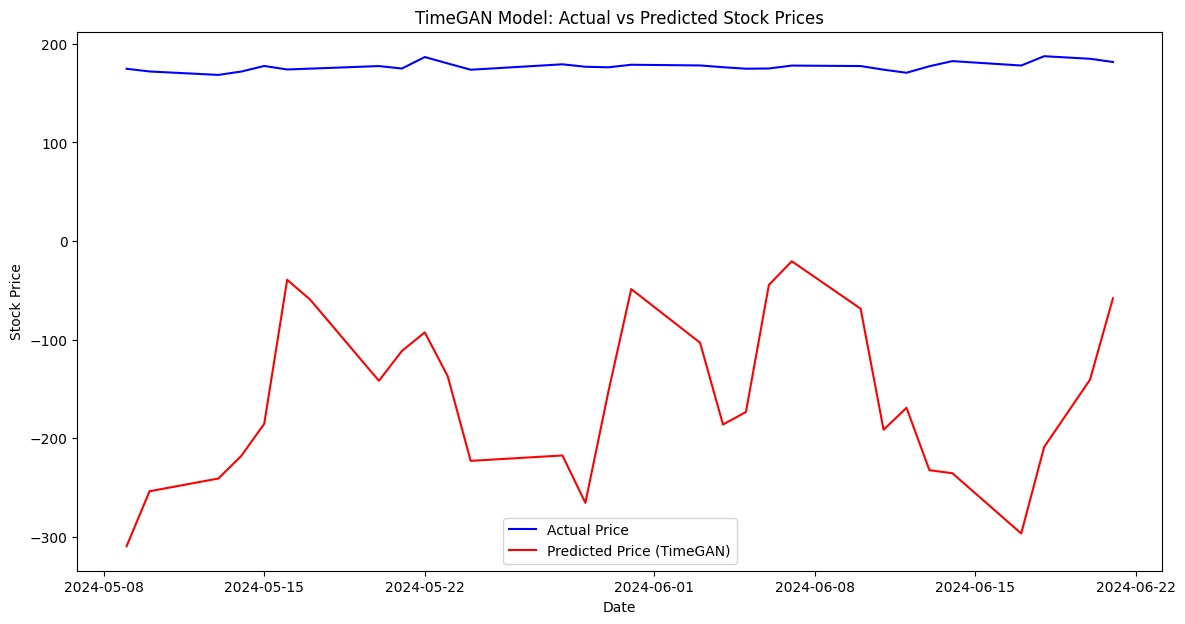

TimeGAN Model MSE: 120670.088237232


In [ ]:
# Extract the last 30 days from the original test data
actual_prices = scaler.inverse_transform(test_data.reshape(-1, 1))[-30:].flatten()
predicted_prices = synthetic_data[-30:].flatten()

# Dates for the last 30 days
dates = df.index[-30:]

# Plot TimeGAN results
plt.figure(figsize=(14, 7))
plt.plot(dates, actual_prices, color='blue', label='Actual Price')
plt.plot(dates, predicted_prices, color='red', label='Predicted Price (TimeGAN)')
plt.title('TimeGAN Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate metrics
from sklearn.metrics import mean_squared_error
mse_timegan = mean_squared_error(actual_prices, predicted_prices)
print(f'TimeGAN Model MSE: {mse_timegan}')
